In [1]:
import re
import unicodedata
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('inflation_readme.csv', index_col=0)
df.head()

,repo,language,readme_contents
0,cashapp/InflationInject,Kotlin,# Inflation Injection\n\nConstructor-inject vi...
1,InflationX/ViewPump,Kotlin,ViewPump\n========\n\nView inflation you can i...
2,rdeits/iris-distro,Matlab,Introduction\n============\n\nThis package con...
3,uhussain/WebCrawlerForOnlineInflation,Python,# Table of Contents \n1. [Introduction](README...
4,sandes/zipfly,Python,[![Build Status](https://img.shields.io/circle...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848 entries, 0 to 847
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             848 non-null    object
 1   language         727 non-null    object
 2   readme_contents  611 non-null    object
dtypes: object(3)
memory usage: 26.5+ KB


In [4]:
df.isnull().sum()

repo                 0
language           121
readme_contents    237
dtype: int64

In [5]:
df[df.readme_contents.isnull()]

,repo,language,readme_contents
17,future-tense/pool.futuretense.io,HTML,NaN
19,gwern/gwern.net,Haskell,NaN
55,kranthikittu/Android_inflation,Kotlin,NaN
60,itamarcaspi/core-inflation,HTML,NaN
67,motherjones/inflation-calculator,NaN,NaN
...,...,...,...
842,LUNDR/inflation_forecasts_with_tf,Jupyter Notebook,NaN
843,millerngit/RateOfInflation,C++,NaN
844,iamdingkai/what-s-driving-inflation,Jupyter Notebook,NaN
846,fscheler/Inflation_Tracker_World,HTML,NaN


In [6]:
# drop the null value

In [7]:
df = df.dropna()
df.shape

(523, 3)

In [8]:
df.language.value_counts().head(10)

Python              102
Jupyter Notebook     96
JavaScript           61
R                    55
HTML                 46
Java                 24
C++                  13
TypeScript           13
CSS                  10
TeX                   9
Name: language, dtype: int64

In [9]:
# all jupyter notebook will change to Python
df.language = np.where(df.language == 'Jupyter Notebook', 'Python', df.language)
df.language = np.where((df.language != 'Python') & (df.language != 'R') & (df.language != 'JavaScript'), 'Other', df.language)

In [10]:
df.language.value_counts().head(10)

Other         209
Python        198
JavaScript     61
R              55
Name: language, dtype: int64

### Prepare

In [11]:
def basic_clean(text):
    article = text.lower()
    article = unicodedata.normalize('NFKD', article)\
    .encode('ascii', 'ignore')\
    .decode('utf-8', 'ignore')
    article = re.sub(r"[^a-z0-9'\s]", '', article)
    return article 

In [12]:
def tokenize(basic_clean_text):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    article = tokenizer.tokenize(basic_clean_text, return_str=True)
    return article

In [13]:
def stem(tokenized_text):
    ps = nltk.stem.porter.PorterStemmer()
    stems = [ps.stem(word) for word in tokenized_text.split()]
    article_stemmed = ' '.join(stems)
    return stems  

In [14]:
def lemmatize(tokenized_text):    
    wnl = nltk.stem.WordNetLemmatizer()    
    lemmas = [wnl.lemmatize(word) for word in tokenized_text.split()]    
    lemmatized_string = ' '.join(lemmas)    
    return lemmatized_string

In [15]:
def remove_stopwords(string, extra_words=None, exclude_words=None):    
    stopword_list = stopwords.words('english')    
    if exclude_words:        
        stopword_list = stopword_list + exclude_words
        
    if extra_words:        
        for word in extra_words:            
            stopword_list.remove(word)
            
    words = string.split()    
    filtered_words = [word for word in words if word not in stopword_list]    
    filtered_string = ' '.join(filtered_words)   
    return filtered_string

# no_stop = remove_stopwords(lemmatized)

In [16]:
# extra_words = ['the','no']
# no_stop1 = remove_stopwords(lemmatized, extra_words=extra_words)
# no_stop1

In [17]:
df['clean'] = df['readme_contents'].apply(basic_clean).apply(tokenize).apply(remove_stopwords)
df['lemmatized'] = df['clean'].apply(lemmatize)
df['stem'] = df['clean'].apply(stem)
df.head()

,repo,language,readme_contents,clean,lemmatized,stem
0,cashapp/InflationInject,Other,# Inflation Injection\n\nConstructor-inject vi...,inflation injection constructorinject views xm...,inflation injection constructorinject view xml...,"[inflat, inject, constructorinject, view, xml,..."
1,InflationX/ViewPump,Other,ViewPump\n========\n\nView inflation you can i...,viewpump view inflation intercept viewpump ins...,viewpump view inflation intercept viewpump ins...,"[viewpump, view, inflat, intercept, viewpump, ..."
2,rdeits/iris-distro,Other,Introduction\n============\n\nThis package con...,introduction package contains iris algorithm i...,introduction package contains iris algorithm i...,"[introduct, packag, contain, iri, algorithm, i..."
3,uhussain/WebCrawlerForOnlineInflation,Python,# Table of Contents \n1. [Introduction](README...,table contents 1 introductionreadmemdintroduct...,table content 1 introductionreadmemdintroducti...,"[tabl, content, 1, introductionreadmemdintrodu..."
4,sandes/zipfly,Python,[![Build Status](https://img.shields.io/circle...,build statushttpsimgshieldsiocirclecibuildgith...,build statushttpsimgshieldsiocirclecibuildgith...,"[build, statushttpsimgshieldsiocirclecibuildgi..."


In [18]:
df.language.value_counts().head(10)

Other         209
Python        198
JavaScript     61
R              55
Name: language, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 0 to 839
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             523 non-null    object
 1   language         523 non-null    object
 2   readme_contents  523 non-null    object
 3   clean            523 non-null    object
 4   lemmatized       523 non-null    object
 5   stem             523 non-null    object
dtypes: object(6)
memory usage: 28.6+ KB


### split the data

In [20]:
from sklearn.model_selection import train_test_split

def split_data(df):
    train_validate, test = train_test_split(df,test_size=0.2, random_state=123)
    train, validate = train_test_split(train_validate,test_size=0.3, random_state=123)
    
    return train, validate, test

In [21]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((292, 6), (126, 6), (105, 6))

### only pick top 3 to predict

In [22]:
ADDITIONAL_STOPWORDS = ['1','2','3','4','5','u']

def clean(text):
    'A simple function to cleanup data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [23]:
python_words = clean(' '.join(train[train.language == 'Python'].readme_contents))
javascript_words = clean(' '.join(train[train.language == 'JavaScript'].readme_contents))
r_words = clean(' '.join(train[train.language == 'R'].readme_contents))
other_words = clean(' '.join(train[train.language == 'Other'].readme_contents))
all_words = clean(' '.join(train.readme_contents))

In [24]:
python_freq = pd.Series(python_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

word_counts = (pd.concat([all_freq, python_freq, javascript_freq,r_freq, other_freq], axis=1, sort=True)
                .set_axis(['all', 'python', 'javascript','r','other'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

1. What are the most common words in READMEs?

In [25]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,python,javascript,r,other
inflation,593,290,21,77,205
data,403,241,28,49,85
file,206,48,33,23,102
price,195,133,5,7,50
code,181,55,14,23,89
rate,178,109,1,39,29
model,172,103,1,9,59
project,158,52,24,27,55
run,149,40,30,7,72
using,147,87,5,6,49


In [51]:
word_counts.sort_values(by='all', ascending=False).tail(20)

,all,python,javascript,r,other
costlier,1,0,0,1,0
costco,1,1,0,0,0
lumenaut,1,0,0,0,1
corrente,1,0,0,0,1
corresponde,1,0,0,0,1
m03,1,0,0,0,1
m01,1,0,0,0,1
corrispondono,1,0,0,0,1
lwe,1,0,0,0,1
lung,1,1,0,0,0


2. Does the length of the README vary by programming language?

In [26]:
train['readme_lenth'] = train.lemmatized.str.len()
train.head()

,repo,language,readme_contents,clean,lemmatized,stem,readme_lenth
744,EuranetPlus/inflation-rate-april,JavaScript,## About this project\n\nThis is the code repo...,project code repository interactive euranetplu...,project code repository interactive euranetplu...,"[project, code, repositori, interact, euranetp...",9233
99,letsgoexploring/sargent-phillips-curve,Python,# sargentPhillipsCurve\nPrograms for replicati...,sargentphillipscurve programs replicating figu...,sargentphillipscurve program replicating figur...,"[sargentphillipscurv, program, replic, figur, ...",93
753,ONSdigital/dp-inflation-helper,Other,Inflation helper\n================\n\nTool to ...,inflation helper tool help guide users specifi...,inflation helper tool help guide user specific...,"[inflat, helper, tool, help, guid, user, speci...",699
824,AxodusDAO/inflation-control-contracts,Other,# Advanced Sample Hardhat Project\n\nThis proj...,advanced sample hardhat project project demons...,advanced sample hardhat project project demons...,"[advanc, sampl, hardhat, project, project, dem...",1544
170,UtsabKafle/inflation,JavaScript,# inflation\nPersonal finance tracer (web base...,inflation personal finance tracer web based ne...,inflation personal finance tracer web based ne...,"[inflat, person, financ, tracer, web, base, ne...",691


In [27]:
train.groupby('language').readme_lenth.mean().sort_values(ascending=False).head()

language
Python        1107.265487
Other          990.040650
JavaScript     911.423077
R              834.333333
Name: readme_lenth, dtype: float64

3. Do different programming languages use a different number of unique words?

In [28]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,python,javascript,r,other
inflation,593,290,21,77,205
data,403,241,28,49,85
file,206,48,33,23,102
price,195,133,5,7,50
code,181,55,14,23,89
rate,178,109,1,39,29
model,172,103,1,9,59
project,158,52,24,27,55
run,149,40,30,7,72
using,147,87,5,6,49


4. Are there any words that uniquely identify a programming language?

# Proporitons bar graphs

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

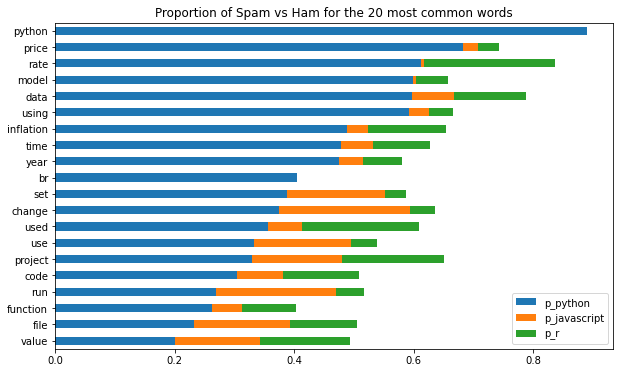

In [29]:
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_javascript=word_counts.javascript / word_counts['all'],
         p_r=word_counts.r / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript','p_r']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True,figsize=(10, 6)))

plt.title('Proportion of Programming Language for the 20 most common words')

# Word Cloud

# Python

In [ ]:
python_words = clean(' '.join(train[train.language == 'Python'].readme_contents))
javascript_words = clean(' '.join(train[train.language == 'JavaScript'].readme_contents))
r_words = clean(' '.join(train[train.language == 'R'].readme_contents))
other_words = clean(' '.join(train[train.language == 'Other'].readme_contents))
all_words = clean(' '.join(train.readme_contents))

In [57]:
python_cloud = ' '.join(python_words)
r_cloud = ' '.join(r_words)
java_cloud = ' '.join(javascript_words)
other_cloud = ' '.join(other_words)
all_cloud = ' '.join(all_words)

Text(0.5, 1.0, 'Python Readme Word Cloud')

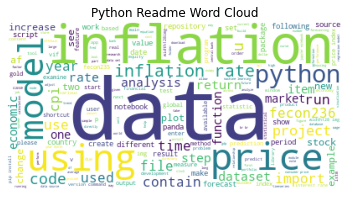

In [60]:
img = WordCloud(background_color='white').generate(python_cloud)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python Readme Word Cloud')

Text(0.5, 1.0, 'R Readme Word Cloud')

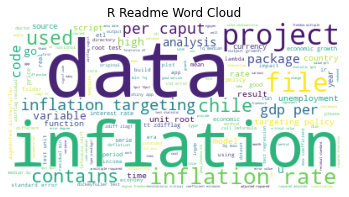

In [61]:
img = WordCloud(background_color='white').generate(r_cloud)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('R Readme Word Cloud')

Text(0.5, 1.0, 'Javascript Readme Word Cloud')

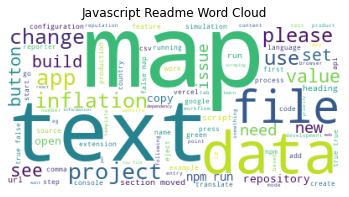

In [62]:
img = WordCloud(background_color='white').generate(java_cloud)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Javascript Readme Word Cloud')

Text(0.5, 1.0, 'Other Readme Word Cloud')

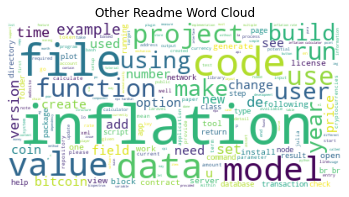

In [63]:
img = WordCloud(background_color='white').generate(other_cloud)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Other Readme Word Cloud')

Text(0.5, 1.0, 'All Readme Word Cloud')

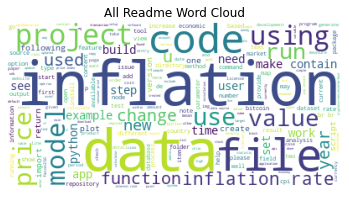

In [64]:
img = WordCloud(background_color='white').generate(all_cloud)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('All Readme Word Cloud')

# Takeaway

Inflation and data are the biggest for python, r, and all. Java focused on map, text, and data. Other focused on inflation, file, code and model. Seems like we might be able to separate out Java and other fairly easily but python and r sahre a lot of similarities and may be more difficult to isolate. 

## Modeling

In [30]:
train.language.value_counts()

Other         123
Python        113
R              30
JavaScript     26
Name: language, dtype: int64

In [31]:
train['baseline'] = 'Other'

baseline_accuracy = (train.language == train.baseline).mean()

print(f'baseline accuracy on train set: {baseline_accuracy:.2%}')

baseline accuracy on train set: 42.12%


In [32]:
def x_train_split(x_data, y_data):
    ''' Further splitting for x & y train,validate,test
    '''
    x_train_validate, x_test, y_train_validate, y_test = train_test_split(x_data, y_data, 
                                                                          stratify = y_data, 
                                                                          test_size=.2, random_state=123)
    
    x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, 
                                                                stratify = y_train_validate, 
                                                                test_size=.3, 
                                                                random_state=123)
    
    return x_train, y_train, x_validate, y_validate, x_test, y_test

## TF-IDF

In [33]:
# definig TfidVectorizer for X and y
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df.lemmatized)
y = df.language

In [34]:
x_train, y_train, x_validate, y_validate, x_test, y_test = x_train_split(x, y)

### 1. Decission Tree TF-IDF

In [35]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))


tree = DecisionTreeClassifier(max_depth=4).fit(x_train, y_train)
train['tree_predicted'] = tree.predict(x_train)
validate['tree_predicted'] = tree.predict(x_validate)
test['tree_predicted'] = tree.predict(x_test)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.tree_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.tree_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.tree_predicted))
print('----------------------------------------------')
print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.tree_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.tree_predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.tree_predicted))

Accuracy: 62.67%
---
Confusion Matrix
actual          JavaScript  Other  Python   R
tree_predicted                               
JavaScript               4      0       0   0
Other                   25    115      46  27
Python                   5      2      64   4
---
              precision    recall  f1-score   support

  JavaScript       1.00      0.12      0.21        34
       Other       0.54      0.98      0.70       117
      Python       0.85      0.58      0.69       110
           R       0.00      0.00      0.00        31

    accuracy                           0.63       292
   macro avg       0.60      0.42      0.40       292
weighted avg       0.65      0.63      0.56       292

----------------------------------------------
Validate Accuracy: 53.17%
---
Confusion Matrix
actual          JavaScript  Other  Python   R
tree_predicted                               
JavaScript               1      2       0   0
Other                   13     46      28  13
Python         

In [36]:
metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(x_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(x_train, y_train)
    
    out_of_sample_accuracy = tree.score(x_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df1 = pd.DataFrame(metrics)
df1["difference"] = df1.train_accuracy - df1.validate_accuracy
df1

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.520548,0.452381,0.068167
1,2,0.561644,0.500000,0.061644
2,3,0.568493,0.500000,0.068493
3,4,0.626712,0.531746,0.094966
4,5,0.650685,0.507937,0.142748
5,6,0.695205,0.484127,0.211078
6,7,0.726027,0.476190,0.249837
7,8,0.753425,0.476190,0.277234
8,9,0.780822,0.484127,0.296695
9,10,0.797945,0.468254,0.329691


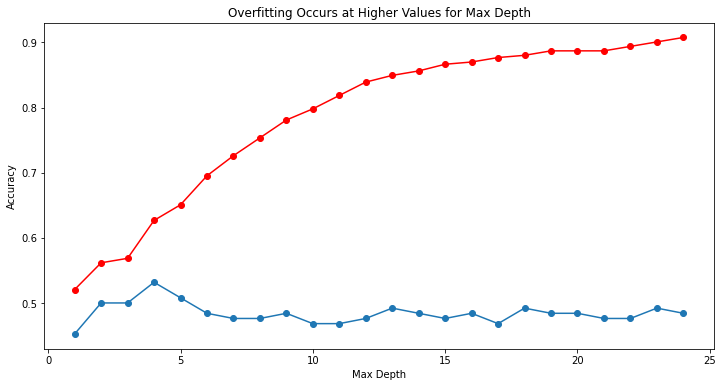

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df1.max_depth, df1.train_accuracy, marker = 'o', color = 'red')
plt.plot(df1.max_depth, df1.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

* max = 4 is the best

### 2. Random Forest TF-IDF

In [38]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

forest = RandomForestClassifier(max_depth = 7, random_state= 123).fit(x_train, y_train)

train['forest_predicted'] = forest.predict(x_train)
validate['forest_predicted'] = forest.predict(x_validate)
test['forest_predicted'] = forest.predict(x_test)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.forest_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.forest_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.forest_predicted))
print('----------------------------------------------')
print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.forest_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.forest_predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.forest_predicted))

Accuracy: 67.81%
---
Confusion Matrix
actual            JavaScript  Other  Python   R
forest_predicted                               
JavaScript                 4      0       0   0
Other                     28    116      33  20
Python                     2      1      77  10
R                          0      0       0   1
---
              precision    recall  f1-score   support

  JavaScript       1.00      0.12      0.21        34
       Other       0.59      0.99      0.74       117
      Python       0.86      0.70      0.77       110
           R       1.00      0.03      0.06        31

    accuracy                           0.68       292
   macro avg       0.86      0.46      0.45       292
weighted avg       0.78      0.68      0.62       292

----------------------------------------------
Validate Accuracy: 59.52%
---
Confusion Matrix
actual            JavaScript  Other  Python  R
forest_predicted                              
Other                     13     48      21  6


In [39]:
# ompare in-sample to out-of-sample

metrics = []

for i in range(1,13):
    rf = RandomForestClassifier(max_depth=(i), 
                                random_state=123)
    
    rf = rf.fit(x_train, y_train)
    
    in_sample_accuracy = rf.score(x_train, y_train)
    
    out_of_sample_accuracy = rf.score(x_validate, y_validate)
    
    output = {"max_depth": (i),
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy}
        
    metrics.append(output)
    
df2 = pd.DataFrame(metrics)
df2["difference"] = df2.train_accuracy - df2.validate_accuracy
df2

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.517123,0.460317,0.056806
1,2,0.582192,0.500000,0.082192
2,3,0.616438,0.515873,0.100565
3,4,0.640411,0.539683,0.100728
4,5,0.654110,0.547619,0.106491
5,6,0.678082,0.571429,0.106654
6,7,0.678082,0.595238,0.082844
7,8,0.698630,0.571429,0.127202
8,9,0.726027,0.587302,0.138726
9,10,0.729452,0.555556,0.173896


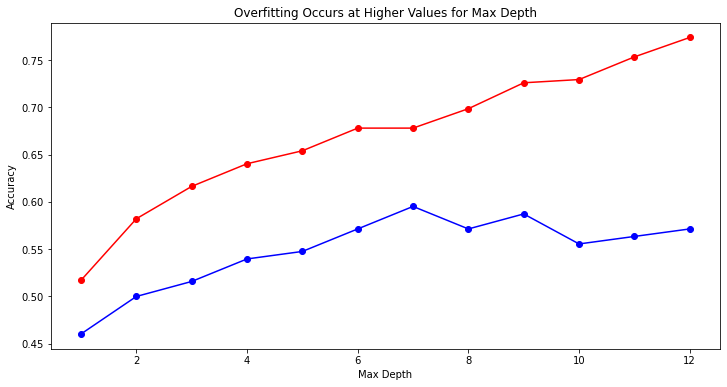

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df2.max_depth, df2.train_accuracy, color = 'r', marker = 'o')
plt.plot(df2.max_depth, df2.validate_accuracy, color = 'b', marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

* max = 3

## Bag of words

In [41]:
# Count Vectorizer using bag of words - defining X & y variables
cv = CountVectorizer()
x1 = cv.fit_transform(df.lemmatized)
y1 = df.language

# function as above
x_train1, y_train1, x_validate1, y_validate1, x_test1, y_test1 = x_train_split(x1, y1)

### 1. Bag of Words Decision Tree 

In [42]:
metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(x_train1, y_train1)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(x_train1, y_train1)
    
    out_of_sample_accuracy = tree.score(x_validate1, y_validate1)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df3 = pd.DataFrame(metrics)
df3["difference"] = df3.train_accuracy - df3.validate_accuracy
df3

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.517123,0.452381,0.064742
1,2,0.558219,0.500000,0.058219
2,3,0.561644,0.500000,0.061644
3,4,0.616438,0.531746,0.084692
4,5,0.650685,0.484127,0.166558
5,6,0.678082,0.492063,0.186019
6,7,0.691781,0.476190,0.215590
7,8,0.722603,0.492063,0.230539
8,9,0.743151,0.484127,0.259024
9,10,0.763699,0.484127,0.279572


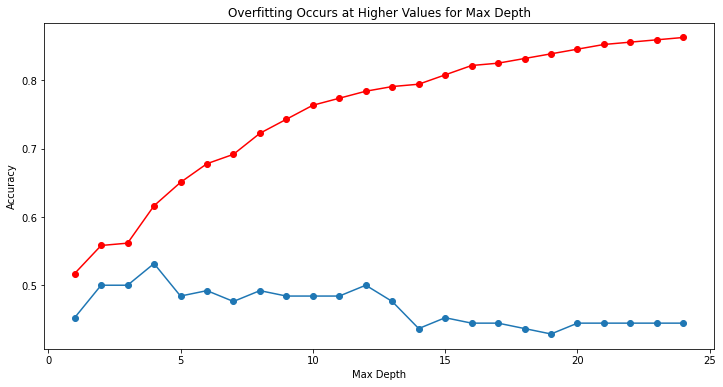

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(df3.max_depth, df3.train_accuracy, marker = 'o', color = 'red')
plt.plot(df3.max_depth, df3.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

* max = 4

In [44]:
train = pd.DataFrame(dict(actual=y_train1))
validate = pd.DataFrame(dict(actual=y_validate1))
test = pd.DataFrame(dict(actual=y_test1))


tree = DecisionTreeClassifier(max_depth=4).fit(x_train1, y_train1)
train['tree_predicted'] = tree.predict(x_train1)
validate['tree_predicted'] = tree.predict(x_validate1)
test['tree_predicted'] = tree.predict(x_test1)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.tree_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.tree_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.tree_predicted))
print('----------------------------------------------')
print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.tree_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.tree_predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.tree_predicted))

Accuracy: 61.64%
---
Confusion Matrix
actual          JavaScript  Other  Python   R
tree_predicted                               
JavaScript               3      0       0   1
Other                   26    112      45  25
Python                   5      5      65   5
---
              precision    recall  f1-score   support

  JavaScript       0.75      0.09      0.16        34
       Other       0.54      0.96      0.69       117
      Python       0.81      0.59      0.68       110
           R       0.00      0.00      0.00        31

    accuracy                           0.62       292
   macro avg       0.53      0.41      0.38       292
weighted avg       0.61      0.62      0.55       292

----------------------------------------------
Validate Accuracy: 53.17%
---
Confusion Matrix
actual          JavaScript  Other  Python   R
tree_predicted                               
JavaScript               1      1       0   0
Other                   13     47      29  13
Python         

### 2. Bag of Words Random Forest

In [45]:
metrics = []

for i in range(1,13):
    rf = RandomForestClassifier(max_depth=(i), 
                                random_state=123)
    
    rf = rf.fit(x_train1, y_train1)
    
    in_sample_accuracy = rf.score(x_train1, y_train1)
    
    out_of_sample_accuracy = rf.score(x_validate1, y_validate1)
    
    output = {"max_depth": (i),
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy}
        
    metrics.append(output)
    
df4 = pd.DataFrame(metrics)
df4["difference"] = df4.train_accuracy - df4.validate_accuracy
df4

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.517123,0.460317,0.056806
1,2,0.571918,0.492063,0.079854
2,3,0.609589,0.515873,0.093716
3,4,0.647260,0.539683,0.107578
4,5,0.664384,0.531746,0.132638
5,6,0.671233,0.531746,0.139487
6,7,0.678082,0.531746,0.146336
7,8,0.695205,0.531746,0.163459
8,9,0.702055,0.523810,0.178245
9,10,0.715753,0.531746,0.184007


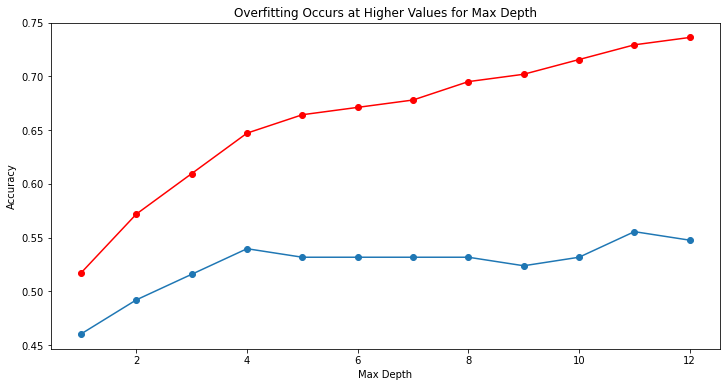

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(df4.max_depth, df4.train_accuracy, marker = 'o', color = 'red')
plt.plot(df4.max_depth, df4.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

* max = 11

In [47]:
train = pd.DataFrame(dict(actual=y_train1))
validate = pd.DataFrame(dict(actual=y_validate1))
test = pd.DataFrame(dict(actual=y_test1))

forest = RandomForestClassifier(max_depth = 11, random_state= 123).fit(x_train1, y_train1)

train['forest_predicted'] = forest.predict(x_train1)
validate['forest_predicted'] = forest.predict(x_validate1)
test['forest_predicted'] = forest.predict(x_test1)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.forest_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.forest_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.forest_predicted))
print('----------------------------------------------')
print('Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.forest_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.forest_predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.forest_predicted))

Accuracy: 72.95%
---
Confusion Matrix
actual            JavaScript  Other  Python   R
forest_predicted                               
JavaScript                 7      0       0   0
Other                     27    116      24  22
Python                     0      1      86   5
R                          0      0       0   4
---
              precision    recall  f1-score   support

  JavaScript       1.00      0.21      0.34        34
       Other       0.61      0.99      0.76       117
      Python       0.93      0.78      0.85       110
           R       1.00      0.13      0.23        31

    accuracy                           0.73       292
   macro avg       0.89      0.53      0.54       292
weighted avg       0.82      0.73      0.69       292

----------------------------------------------
Validate Accuracy: 55.56%
---
Confusion Matrix
actual            JavaScript  Other  Python  R
forest_predicted                              
Other                     13     44      22  6


## test

In [48]:
test = pd.DataFrame(dict(actual=y_test))

forest = RandomForestClassifier(max_depth = 7, random_state= 123).fit(x_train, y_train)

test['forest_predicted'] = forest.predict(ßx_test)

print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.forest_predicted)))

NameError: name 'ßx_test' is not defined